In [58]:
import sys
from pathlib import Path
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import importlib

# 讓 Python 找得到 src 資料夾
# 假設 notebook 在專案根目錄 (跟 src 同層)
sys.path.append(str(Path.cwd()))

# 設定繪圖風格
sns.set_theme(style="whitegrid")
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "Microsoft JhengHei"]
plt.rcParams["axes.unicode_minus"] = False

In [59]:
# 取得目前 notebook 的路徑 (例如 D:\NCKU\paper4\script)
current_dir = Path.cwd()

# 取得上一層目錄 (專案根目錄，例如 D:\NCKU\paper4)
project_root = current_dir.parent

# 把根目錄加入 Python 的搜尋路徑
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"已加入專案路徑: {project_root}")

# reload
to_delete = [m for m in sys.modules if m.startswith("src")]

for m in to_delete:
    del sys.modules[m]

print(f"已清理模組: {to_delete}")

import src.utils.data_loader as data_loader
import src.engine.trainer as trainer
import src.utils.helpers as helpers
import src.engine.evaluator as evaluator

# 硬體設定
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

已清理模組: ['src', 'src.utils', 'src.utils.data_loader', 'src.engine', 'src.models', 'src.models.layers', 'src.models.network', 'src.utils.metrics', 'src.engine.trainer', 'src.utils.helpers', 'src.engine.evaluator']
Running on: cuda


In [60]:
helpers.set_seed(42)

# 全域設定
DATA_PATH = Path("../dataset/USD_TWD.csv")
HORIZON = 3
LOOKBACK = 30
EPOCHS = 100
LR = 0.001
SEED = 42
TREND_CNNEXPERT_KERNELSIZE = 13
SEASONAL_CNNEXPERT_KERNELSIZE = 9
SERIESDECOMPOSITION_KERNELSIZE = 15

# 設定隨機性 (Reproducibility)
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


Seed set to: 42 (Deterministic mode ON)


In [61]:
if not DATA_PATH.exists():
    raise FileNotFoundError("找不到資料集！")

df = pd.read_csv(DATA_PATH)

# 載入資料
train_loader, val_loader, test_loader, scalers = data_loader.prepare_data(
    df, lookback=LOOKBACK, horizon=HORIZON
)

print(
    f"Data ready. Train batches: {len(train_loader)}, Test batches: {len(test_loader)}"
)

[Data Split]
  Train: 4724 samples
  Val  : 678 samples
  Test : 1357 samples
Data ready. Train batches: 147, Test batches: 43


In [62]:
ablation_experiments = [
    {
        "name": "Seasonal CNN only",
        "params": {
            "use_seasonal_cnn": True,
            "use_trend_cnn": False,
        },
    },
    {
        "name": "Trend CNN only",
        "params": {"use_seasonal_cnn": False, "use_trend_cnn": True},  # 啟用 Trend CNN
    },
    {
        "name": "w/o CNN",
        "params": {"use_seasonal_cnn": False, "use_trend_cnn": False},  # 關閉 CNN
    },
    {
        "name": "Full CNN Model",
        "params": {"use_seasonal_cnn": True, "use_trend_cnn": True},  # 啟用 CNN
    },
    {
        "name": "w/o Decomposition",
        "params": {
            "use_seasonal_cnn": True,
            "use_trend_cnn": True,
            "use_decomp": False,
        },  # 關閉序列分解
    },
    {
        "name": "w/o learnable",
        "params": {
            "use_seasonal_cnn": True,
            "use_trend_cnn": True,
            "use_learnable": False,
        },
    },
]

In [63]:
results = []

print(f"開始執行 {len(ablation_experiments)} 組消融實驗...\n")

for i, exp in enumerate(ablation_experiments):
    exp_name = exp["name"]
    exp_params = exp["params"]

    print(f"[{i + 1}/{len(ablation_experiments)}] Running: {exp_name}")
    print(f"   Params: {exp_params}")

    # === [關鍵修正] 重設種子，確保每次實驗起跑點完全公平 ===
    helpers.set_seed(SEED)

    # 2. 訓練模型
    model = trainer.train_v11(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=DEVICE,
        horizon=HORIZON,
        num_epochs=EPOCHS,
        seq_len=LOOKBACK,
        lr=LR,
        trendCNNExpert_KernelSize=TREND_CNNEXPERT_KERNELSIZE,
        seasonalCNNExpert_KernelSize=SEASONAL_CNNEXPERT_KERNELSIZE,
        seriesDecomposition_KernelSize=SERIESDECOMPOSITION_KERNELSIZE,
        model_hyperparams=exp_params,
    )

    # 3. 評估模型 (使用最新的 evaluator，會回傳策略回測結果)
    metrics = evaluator.evaluate_model(
        model=model,
        test_loader=test_loader,
        device=DEVICE,
        horizon=HORIZON,
        scaler=scalers,
    )

    # 4. 儲存結果
    record = {"Experiment": exp_name}

    # 這裡會自動存入 Sharpe_Strategy, Cum_Ret_Strategy 等新欄位
    record.update(metrics)
    results.append(record)

    # 印出 RMSE 確認
    rmse = metrics.get("RMSE_Final", 0.0)
    print(f"   Result: RMSE={rmse:.4f}\n")

print("所有實驗結束！")

開始執行 6 組消融實驗...

[1/6] Running: Seasonal CNN only
   Params: {'use_seasonal_cnn': True, 'use_trend_cnn': False}
Seed set to: 42 (Deterministic mode ON)
Learnable Moving Average Decomposition Enabled
Trend CNN Expert Disabled
Seasonal CNN Expert Enabled

[Training] Enhanced DLinear...
Epoch   1 | LR: 0.001000 | Train: 0.4203 | Val: 0.3556 | Trend W: 0.000 | Seas W: 0.539
Epoch  10 | LR: 0.001000 | Train: 0.3476 | Val: 0.3384 | Trend W: 0.000 | Seas W: 0.323
Epoch  20 | LR: 0.001000 | Train: 0.3366 | Val: 0.3308 | Trend W: 0.000 | Seas W: 0.289
Epoch  30 | LR: 0.001000 | Train: 0.3287 | Val: 0.3333 | Trend W: 0.000 | Seas W: 0.289
Epoch  40 | LR: 0.000250 | Train: 0.3202 | Val: 0.3336 | Trend W: 0.000 | Seas W: 0.308
[Early Stopping] No improvement for 20 epochs. Stopped at epoch 45.

[Training Completed] Loading best model (Val Loss: 0.3285)...

 FINAL MODEL EVALUATION (Horizon=1) | Ablation & Backtest
Metric               | Linear Base     | Base + CNN      | Improvement    
----------


=== Ablation Study Results ===


,Experiment,RMSE_Final,R2_Final,Avg_Acc,High_Vol_Acc,Sharpe_Strategy,Cum_Ret_Strategy,Sharpe_Benchmark
0,Seasonal CNN only,1.0231,0.9152,0.7126,0.8934,0.6466,0.1451,0.3202
1,Trend CNN only,1.0245,0.9150,0.7082,0.9007,0.7002,0.1575,0.3202
2,w/o CNN,1.1652,0.8900,0.5984,0.7096,0.5482,0.1226,0.3202
3,Full CNN Model,1.0090,0.9175,0.7133,0.8897,0.7555,0.1725,0.3202
4,w/o Decomposition,1.0877,0.9041,0.7133,0.8787,0.5459,0.1220,0.3202
5,w/o learnable,1.0647,0.9082,0.6949,0.8529,0.5921,0.1339,0.3202


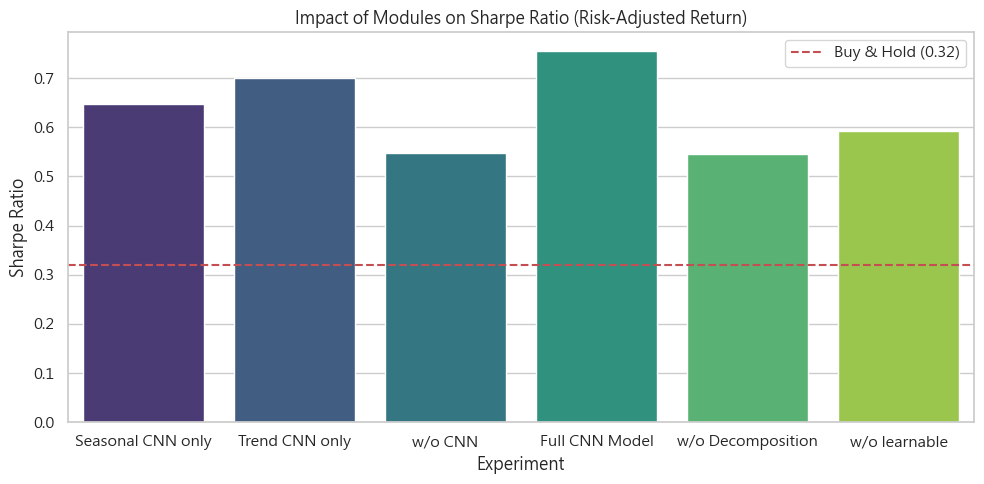

In [64]:
# [Cell 49] 顯示 Ablation Study 結果 (修正 Seaborn 警告版)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("\n=== Ablation Study Results ===")

if not results:
    print("沒有結果可以顯示，請確認上一個 Cell 是否執行成功。")
else:
    # 1. 轉成 DataFrame
    df_res = pd.DataFrame(results)

    # 2. 選擇要顯示的關鍵欄位
    display_cols = [
        "Experiment",
        "RMSE_Final",
        "R2_Final",
        "Avg_Acc",
        "High_Vol_Acc",
        "Sharpe_Strategy",
        "Cum_Ret_Strategy",
        "Sharpe_Benchmark",
    ]

    # 3. 確保欄位存在
    final_cols = [c for c in display_cols if c in df_res.columns]

    # 建立顯示專用的子表格
    df_display = df_res[final_cols]

    # 4. 顯示並 Highlight 最佳值
    display(
        df_display.style.highlight_min(subset=["RMSE_Final"], color="green", axis=0)
        .highlight_max(
            subset=[
                c
                for c in [
                    "R2_Final",
                    "Avg_Acc",
                    "High_Vol_Acc",
                    "Sharpe_Strategy",
                    "Cum_Ret_Strategy",
                ]
                if c in final_cols
            ],
            color="green",
            axis=0,
        )
        .format(
            "{:.4f}",
            subset=pd.IndexSlice[:, df_display.select_dtypes(include="float").columns],
        )
    )

    # 5. 簡單繪圖比較 Sharpe Ratio
    if "Sharpe_Strategy" in df_res.columns:
        plt.figure(figsize=(10, 5))

        # === [修正重點] 加入 hue="Experiment" 和 legend=False ===
        sns.barplot(
            data=df_res,
            x="Experiment",
            y="Sharpe_Strategy",
            hue="Experiment",  # 新增：指定 hue 變數
            palette="viridis",
            legend=False,  # 新增：隱藏圖例 (因為 x 軸已經有標籤了)
        )

        plt.title("Impact of Modules on Sharpe Ratio (Risk-Adjusted Return)")
        plt.ylabel("Sharpe Ratio")

        # 畫一條 Buy & Hold 的基準線
        if "Sharpe_Benchmark" in df_res.columns:
            benchmark_val = df_res.iloc[0]["Sharpe_Benchmark"]
            plt.axhline(
                benchmark_val,
                color="r",
                linestyle="--",
                label=f"Buy & Hold ({benchmark_val:.2f})",
            )
            plt.legend()

        plt.tight_layout()
        plt.show()